# Retail Data Analysis Project 


### Load Data and dependencies 

In [1]:
# Import dependicies 

import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import chart_studio.plotly as py
import numpy as np 
import seaborn as sns
import os 
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
import pmdarima as pm
import statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import datetime as dt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import data
features = pd.read_csv(r"C:\Users\Siddig\Documents\data_analytics\retaildata\Features data set.csv",
                        parse_dates=True,
                        squeeze=True,)
sales = pd.read_csv(r"C:\Users\Siddig\Documents\data_analytics\retaildata\sales data-set.csv",  
                        parse_dates=True,
                        squeeze=True,)
stores = pd.read_csv(r"C:\Users\Siddig\Documents\data_analytics\retaildata\stores data-set.csv",  
                        
                        squeeze=True,)

### Pre-Process Data 

In [3]:
sales.Date = pd.to_datetime(sales.Date)
features.Date = pd.to_datetime(features.Date)

In [4]:
# features data set - stores and regional data for the given week 
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [5]:
# sales data set - sales for each department in stores from 2010-02-05 to 2012-11-01 
sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [6]:
# stores and their size and type 
stores.head()


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [7]:
# merge sales and features tables for easier use 

df = sales.merge(right = features, on = ['Store', 'Date', 'IsHoliday'])
df.head()



,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,2,2010-05-02,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
2,1,3,2010-05-02,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
3,1,4,2010-05-02,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
4,1,5,2010-05-02,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106


In [8]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   int64         
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 712.0 KB


In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  int64         
 1   Dept          421570 non-null  int64         
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), datetime64[ns](1), float64(1), int64(2)
memory usage: 13.3 MB


In [10]:
stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [11]:
# add type of store and size to dataframe 

df = df.merge(right = stores, on = ['Store'])
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-05-02,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-05-02,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-05-02,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-05-02,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-05-02,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


In [12]:
# Check for missing values missing values for markdowns 

df.isnull().sum()

#create column with all total markdowns in them

# get rid of markdown columns and add them to a total markdown column for simplicity 
df['MarkdownTotal'] = df['MarkDown1'] + df['MarkDown2']+ df['MarkDown3']+ df['MarkDown4']+ df['MarkDown5']  
df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'],inplace= True, axis =1)



In [13]:

# markdowns with NaN had no markdown in price and thus we will assume be relpace them with 0

df["MarkdownTotal"] = df["MarkdownTotal"].fillna(0)

# also want to format isHoliday in binary format 

df["IsHoliday"] = df["IsHoliday"].astype(int)

df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment,Type,Size,MarkdownTotal
0,1,1,2010-05-02,24924.50,0,42.31,2.572,211.096358,8.106,A,151315,0.0
1,1,2,2010-05-02,50605.27,0,42.31,2.572,211.096358,8.106,A,151315,0.0
2,1,3,2010-05-02,13740.12,0,42.31,2.572,211.096358,8.106,A,151315,0.0
3,1,4,2010-05-02,39954.04,0,42.31,2.572,211.096358,8.106,A,151315,0.0
4,1,5,2010-05-02,32229.38,0,42.31,2.572,211.096358,8.106,A,151315,0.0


In [14]:
# One-Hot Encoding for store "Type" Variable

df["Type"] = df["Type"].astype('category')

df["Type"] = df["Type"].cat.codes


### Exploratory Data Analysis

<AxesSubplot:>

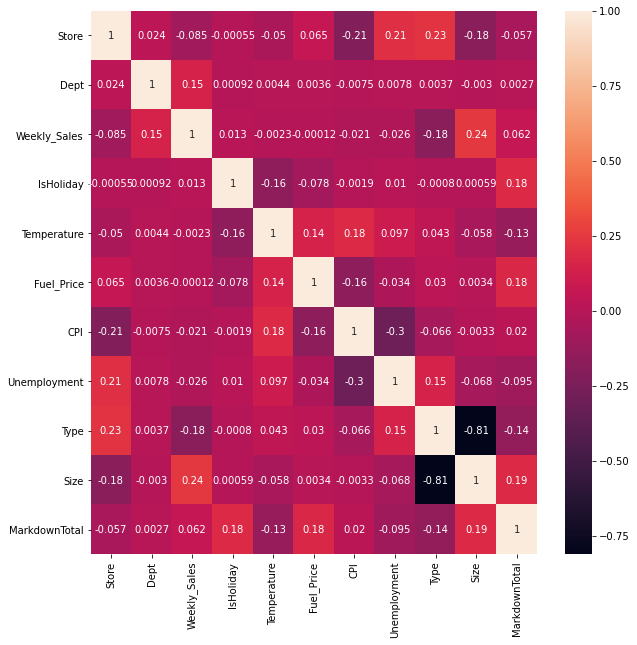

In [15]:
# check correlation between variables

plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(df.corr(),annot=True)


There doesn't seem to be any high correlations of value, however, the Size and Type of store are quite negatively correlated which may be attributed to how the business chooses their stores types. This will come back later.  

In [16]:
# create table with variables of interest over two year period for plotting
grouped_sales = df.groupby('Date').sum()['Weekly_Sales'].reset_index()

grouped_CPI = df.groupby('Date').mean()['CPI'].reset_index()
grouped_Unemploy = df.groupby('Date').mean()['Unemployment'].reset_index()
grouped_Holiday = df.groupby('Date').mean()['IsHoliday'].reset_index()


grouped_CPI_UN = grouped_CPI.merge(right = grouped_Unemploy, on = ['Date'])
grouped_Hol = grouped_CPI_UN.merge(right = grouped_Holiday, on = ['Date'])

grouped = grouped_Hol.merge(right = grouped_sales, on = ['Date'])


grouped.head()


,Date,CPI,Unemployment,IsHoliday,Weekly_Sales
0,2010-01-10,168.004935,8.433960,0,42239875.87
1,2010-02-04,167.377836,8.441092,0,50423831.26
2,2010-02-07,167.663264,8.373801,0,48917484.50
3,2010-02-19,167.338966,8.576351,0,48276993.78
4,2010-02-26,167.691019,8.561375,0,43968571.13


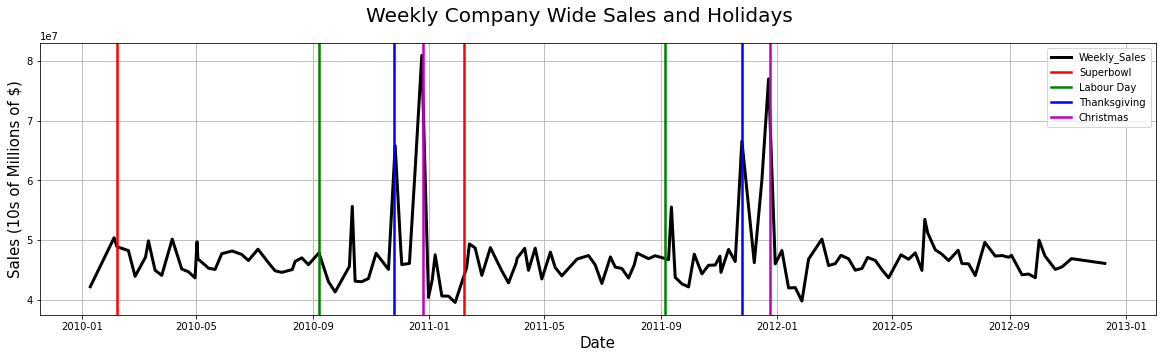

In [36]:
# plot company wide sales and explore holidays

fig, ax1 = plt.subplots()
    
ax1.plot('Date','Weekly_Sales','black',data=grouped, lw=3)

fig.suptitle('Weekly Company Wide Sales and Holidays', fontsize=20)
ax1.set_xlabel('Date',fontsize = 15)
ax1.set_ylabel('Sales (10s of Millions of $)',fontsize = 15)
plt.rcParams["figure.figsize"] = [15,5]

# set holidays for 2010
year2010 = [dt.datetime(2010, 2, 7), dt.datetime(2010, 9,7 ),
        dt.datetime(2010, 11, 25),dt.datetime(2010, 12, 25)] 

# set holidays for 2010
year2011 = [dt.datetime(2011, 2, 6), dt.datetime(2011, 9,5 ), 
     dt.datetime(2011, 11, 25), dt.datetime(2011, 12, 25)]

#set "holidays" considered in dataset 
holidays = ["Superbowl", "Labour Day","Thanksgiving", "Christmas"]

# change colors for holidays
c = ["r", "g", "b", "m"]
for i in range(0,len(year2010)):
    ax1.axvline(pd.to_datetime(year2010[i]), color=c[i], linestyle='-', lw=2.5, label= holidays[i])

for i in range(0,len(year2011)):
    ax1.axvline(pd.to_datetime(year2011[i]), color=c[i], linestyle='-', lw=2.5)
    
plt.grid()
plt.legend()
plt.show()

Looking at the weekly company sales, in general sales tend to be higher during the end of the year, during the holiday shopping season. The weeks that contain a holiday clearly show a spike in sales very closely. While the spike isn't as apparent on weeks that have "holidays" such as the Superbowl and Labour day, weeks near Christmas, Thanksgiving and Black Friday for that matter, show  very high spikes in company wide sales.  

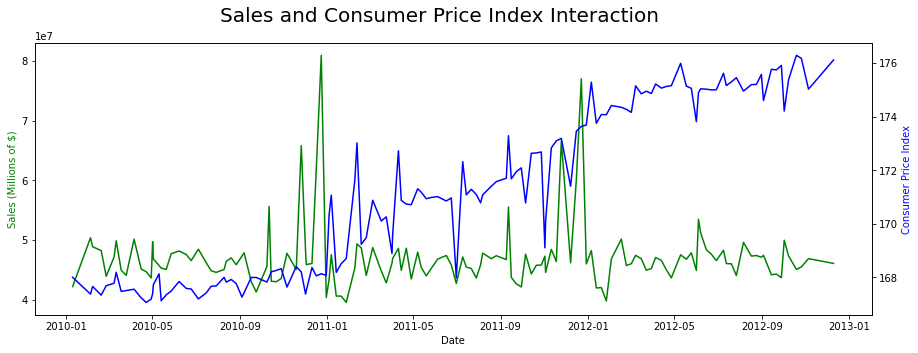

In [18]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.plot('Date','Weekly_Sales','g-',data=grouped)
ax2.plot('Date','CPI','b-',data=grouped)


fig.suptitle('Sales and Consumer Price Index Interaction', fontsize=20)
ax1.set_xlabel('Date')
ax1.set_ylabel('Sales (Millions of $)', color='g')
ax2.set_ylabel('Consumer Price Index', color='b')
plt.rcParams["figure.figsize"] = [15,5]

plt.show()

Over the two year period the consumer price index is steadily increasing howver doesn't directly show a pattern with the pattern of sales.  

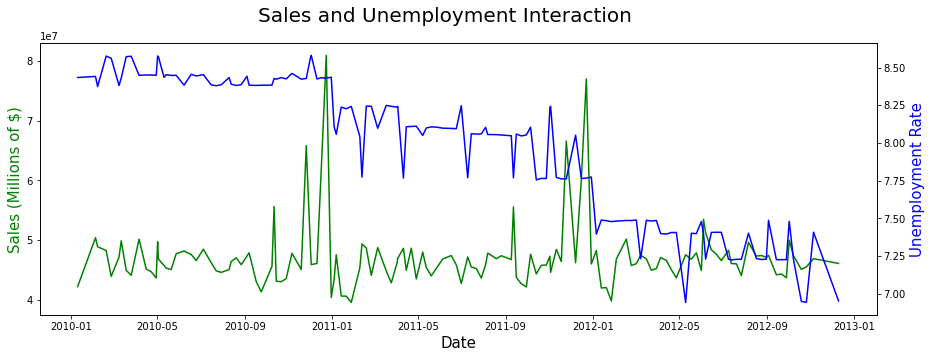

In [19]:

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot('Date','Weekly_Sales','g-',data=grouped)
ax2.plot('Date','Unemployment','b-',data=grouped)

fig.suptitle('Sales and Unemployment Interaction', fontsize=20)
ax1.set_xlabel('Date',fontsize=15)
ax1.set_ylabel('Sales (Millions of $)', color='g', fontsize=15)
ax2.set_ylabel('Unemployment Rate', color='b',fontsize=15)
plt.rcParams["figure.figsize"] = [15,5]

plt.show()

Over the two year period unemployment decreases about 1.5% with sales not showing much interaction or pattern with the sales despite them both showing cyclical patterns. 

Text(0.5, 0.98, 'Store Size and Sales Comparison by Type ')

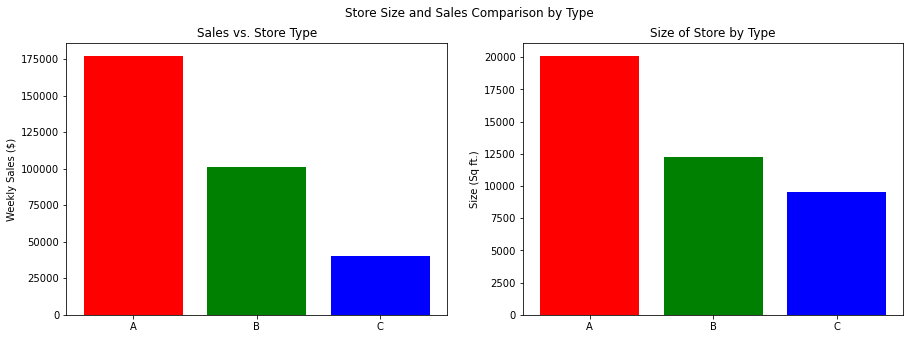

In [20]:
# group data for Type comparisons 
grouped_type = df.groupby('Type').mean()['Weekly_Sales'].reset_index()
grouped_size = stores.groupby('Type').mean()['Size'].reset_index()

grouped_type["Type"] = ["A", "B","C"]

grouped_size

# visualize results 
fig, axs = plt.subplots(1, 2)
axs[0].bar(grouped_size.Type,grouped_size.Size, color=["r","g","b"])
axs[0].set_ylabel("Weekly Sales ($)")
axs[0].title.set_text("Sales vs. Store Type")

axs[1].set_ylabel("Size (Sq ft.)")
axs[1].bar(grouped_type.Type,grouped_type.Weekly_Sales, color=["r","g","b"])
axs[1].title.set_text("Size of Store by Type")

fig.suptitle('Store Size and Sales Comparison by Type ')


As expected from before, we can now visually see the negative correlation as we move from A to C in store size. We can also see average sales are highest on average for stores of Type A followed by Type B and then Type C. This is not suprising as the size of the store for type A is also highest and follows the distribution of the size of the store. Therefore we can expect sales from stores of type A to be the largest followed by type B and C. Next we want to explore the effect of markdowns on weekly sales. 



In [21]:
# Create new column depicting if there was markdowns for that week
df["IsMarkeddown"] = df['MarkdownTotal'] > 0
df["IsMarkeddown"].astype("category").head()

0    False
1    False
2    False
3    False
4    False
Name: IsMarkeddown, dtype: category
Categories (2, object): [False, True]

Text(0.5, 0.98, 'Sales By Markdown Status')

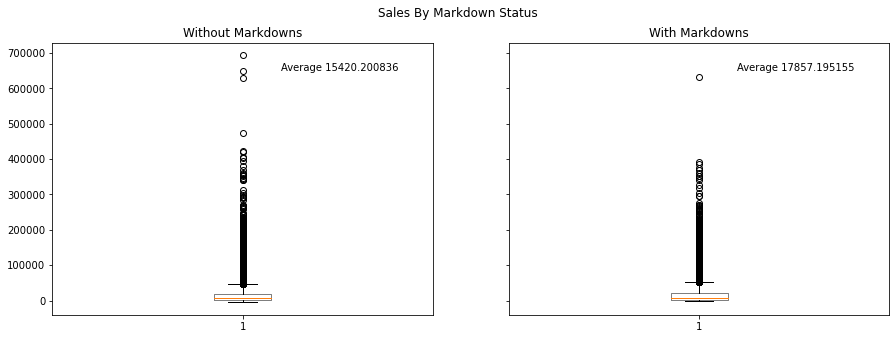

In [22]:
# plot markdown on effects

no_avg = (sum(df[df.IsMarkeddown ==0].Weekly_Sales)) / len(df[df.IsMarkeddown ==0].Weekly_Sales)
yes_avg = (sum(df[df.IsMarkeddown ==1].Weekly_Sales)) / len(df[df.IsMarkeddown ==1].Weekly_Sales)
fig, axs = plt.subplots(1,2,sharey=True)

axs[0].boxplot(df[df.IsMarkeddown ==0].Weekly_Sales,boxprops=dict(alpha=.5)) # labelled as 0 (False = 0)
axs[0].title.set_text("Without Markdowns")
axs[0].annotate("Average %f" % no_avg,(1.1, 650000))
axs[1].boxplot(df[df.IsMarkeddown ==1].Weekly_Sales,boxprops=dict(alpha=.5)) # labelled as 1 (True = 1)
axs[1].annotate("Average %f" % yes_avg,(1.1, 650000))             
axs[1].title.set_text("With Markdowns")

fig.suptitle("Sales By Markdown Status")


The variation is greater for department sales without markdowns that week, however, on average when there is markdowns that week, the sales are generally higher as their average differs by almost 2500. The higher average sales on weeks with markdowns suggests the presence of more markdowns during Christmas, Superbowl, Labour Day, and Thanksgiving weeks, which may explain the higher sales of those give days from above. 

### Forcasting Sales Using Time Series Analysis

 Here we will look to forecast the sales for a particular store and department given,  using Time-Series Forecasting. The model used will be a Auto-regressive Integrated Moving Average (ARIMA) model that gives a prediction of the next 3 months (fiscal quarter) based on the previous data. The ARIMA model is one of the most general cases of time series models and is a form of a regressional analysis. We will test various models of different paramters and compare using the Alkaline Information Criterion (AIC). Lastly, the final model will be compared to our test set and evaluated using Mean Absolute Error (MAE).  

In [23]:
sales1 = pd.read_csv(r"C:\Users\Siddig\OneDrive\data_analytics\retaildata\sales data-set.csv", 
                    index_col=2,
                       parse_dates=True,
                       squeeze=True,)

In [37]:
# Choose store and department we are interesting in 

# for this case we will explore Store #7 and Department 23
series = sales1[sales1["Store"] == 7]
series = series[series["Dept"] == 23]
#get in time-series format
series = series["Weekly_Sales"]


In [25]:
# Adjust index and group data by month for simplicity
series = series.sort_index()
ts = series.resample('M',convention='end').sum()
ts.index = ts.index.strftime('%Y-%m')



In [26]:
# conduct Augmented Dickey-Fuller Test 

result = adfuller(ts)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[0] > result[4]["5%"]:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")
    else:
        print ("Reject Ho - Time Series is Stationary")

ADF Statistic: -5.241557
p-value: 0.000007
Critical Values:
	1%: -3.633
Reject Ho - Time Series is Stationary
	5%: -2.949
Reject Ho - Time Series is Stationary
	10%: -2.613
Reject Ho - Time Series is Stationary


 As expected the Augmented Dickey-Fuller Test for the time-series data is rejected which implies that our data is stationary and thus acceptable to use in our model. 



In [27]:
series.tail(5) # check end of series

Date
2012-10-08    14598.96
2012-10-19    14822.21
2012-10-26    15428.12
2012-11-05     9612.37
2012-12-10    15149.68
Name: Weekly_Sales, dtype: float64

After careful examination, it's evident the sales for the last two months of our data for this store is limited as only one day were recorded for November and December 2012. Therefore, we will remove these two months from our test set as they will contribute to a larger error in prediction from previous months. 

In [28]:
ts = ts.drop(['2012-11','2012-12'])
ts.tail(5)

Date
2012-06    96174.23
2012-07    57219.79
2012-08    56648.18
2012-09    60280.58
2012-10    60326.99
Name: Weekly_Sales, dtype: float64

In [29]:
# split into train and test sets 
train = ts['2010-01':'2012-07']
test  = ts['2012-08':'2012-10']
test

#get dataframe for series 
ts_df = pd.DataFrame(ts)
ts_df.index = pd.to_datetime(ts_df.index)


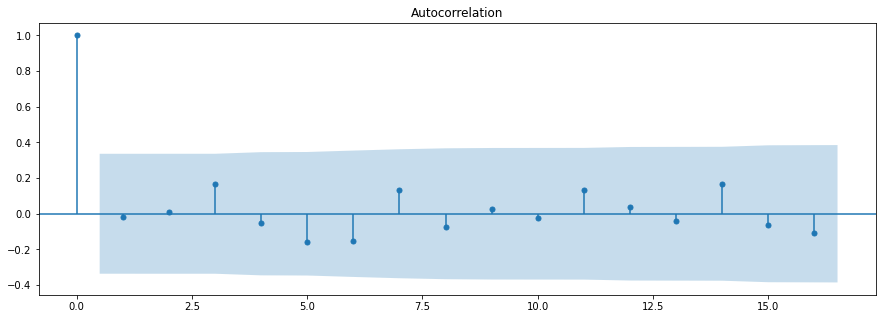

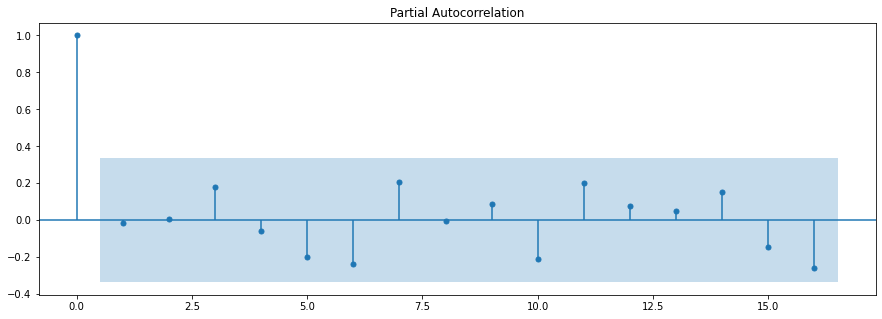

In [30]:
plot_acf(ts)
plt.show()

plot_pacf(ts)
plt.show()

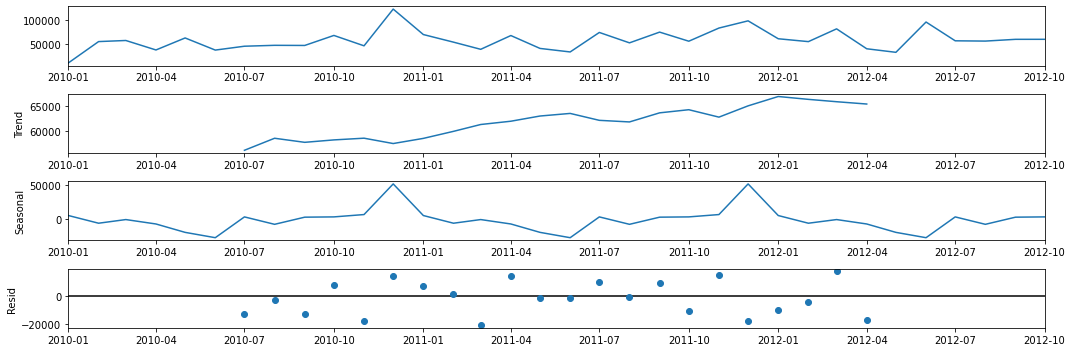

In [31]:
# decomposition plots 
decomposition = sm.tsa.seasonal_decompose(ts_df, model='additive')
fig = decomposition.plot()
plt.show()

We can see an increase in trend of sales over time and also note there is a strong seasonal component which has attributed to our auto arima model. Therefore our model will take this into account when fitting the model as their are more paramters (P,D,Q) involved in cases with seasonality.

In [32]:

stepwise_model = pm.auto_arima(train, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.15 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=441.616, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=431.122, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=438.755, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=433.101, Time=0.09 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=433.102, Time=0.09 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=432.348, Time=0.05 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=435.101, Time=0.26 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=434.415, Time=0.04 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=430.910, Time=0.07 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=442.085, Time=0.03 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=431.381, Time=0.22 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=431.956, Time=0.12 sec
 ARIMA(2,1,0)(0,1,1)[12]             : AI

In [38]:
# fit our model on our training data 
stepwise_model.fit(train)

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

In [34]:
# make prediction for next three instances (months) - August, September, October
pred = stepwise_model.predict(3)

# find Mean Absolute Error (MAE)
mae = mean_absolute_error(test.values,pred)

After making the prediction, we get a MAE of 11501

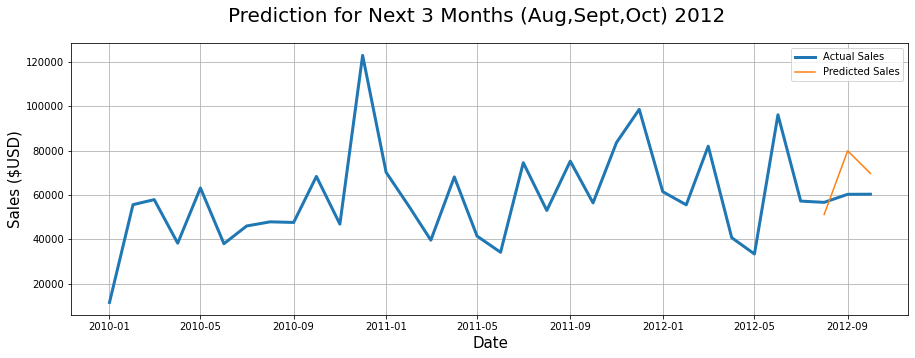

In [39]:
# Plot results 

fig, ax1 = plt.subplots()
    
ax1.plot(ts_df, lw=3, label="Actual Sales")
ax1.plot(pd.to_datetime(test.index),pred,label="Predicted Sales")
fig.suptitle('Prediction for Next 3 Months (Aug,Sept,Oct) 2012', fontsize=20)
ax1.set_xlabel('Date',fontsize = 15)
ax1.set_ylabel('Sales ($USD)',fontsize = 15)

plt.rcParams["figure.figsize"] = [20,5]
plt.grid()
plt.legend()



### Conclusion

Finally, our model has been trained and has attempted to predicted the sales for the "next" fiscal quarter. With a Mean Absolute Error of 11501, and the evident error plotted above, the model isn't perfect but it estimates the Sales to a fair degree. With the limited amount of data the model could use more, and implementing other variables could contribute to better results.  